In [14]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from seaborn import set_style
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from mpl_toolkits import mplot3d
set_style("whitegrid")
import re

In [79]:
clTrials = pd.read_csv("CancerClinicalTrialData.csv")

In [80]:
clTrials

,Rank,Title,Status,Study Results,Conditions,Interventions,Outcome Measures,Gender,Age,Phases,Enrollment,Funded Bys,Study Designs,Start Date,Completion Date,Study Duration (months),Locations,URL
0,1,Immediate-Release Oxycodone Capsules Study in ...,Completed,Has Results,Cancer,Drug: Oxycodone|Drug: Morphine,Numerical Rating Scale (NRS)|The Average Dose ...,All,"18 Years to 80 Years (Adult, Older Adult)",Phase 3,242,Industry,Allocation: Randomized|Intervention Model: Par...,Jan-11,Jul-12,18,NaN,https://ClinicalTrials.gov/show/NCT01675622
1,2,A Phase II Study of Nivolumab in Combination W...,Completed,Has Results,Breast Cancer,Drug: Nivolumab|Drug: Cabozantinib,Overall Response Rate|Number of Participants W...,Female,"18 Years and older (Adult, Older Adult)",Phase 2,18,Other|Industry,Allocation: N/A|Intervention Model: Single Gro...,30-Nov-17,30-Aug-19,21,"Dana-Farber Cancer Institute, Boston, Massachu...",https://ClinicalTrials.gov/show/NCT03316586
2,3,"Radiation, Cetuximab and Pemetrexed With or Wi...",Completed,Has Results,Cancer,Drug: Bevacizumab|Drug: Cetuximab|Drug: Pemetr...,2-year Progression-free Survival (PFS)|2-year ...,All,"18 Years and older (Adult, Older Adult)",Phase 2,80,Other|Industry,Allocation: Randomized|Intervention Model: Sin...,Oct-08,Sep-14,71,"University of Pittsburgh Medical Center, Pitts...",https://ClinicalTrials.gov/show/NCT00703976
3,4,Fulvestrant Plus Enzalutamide in ER+/Her2- Adv...,Completed,Has Results,Breast Cancer,Drug: Fulvestrant with Enzalutamide,Clinical Benefit Rate of the Combination of En...,Female,"18 Years to 100 Years (Adult, Older Adult)",Phase 2,32,Other|U.S. Fed,Allocation: N/A|Intervention Model: Single Gro...,6-Jul-17,10-Apr-20,33,"University of Colorado, Aurora, Colorado, Unit...",https://ClinicalTrials.gov/show/NCT02953860
4,5,PROspective Non-interventional Open laBEl Tria...,Completed,Has Results,Cancer,Drug: Oxycodone/Naloxone,Change in Numeric Rating Scales (NRS) Score|Ch...,All,"20 Years and older (Adult, Older Adult)",Phase 4,359,Industry,Allocation: N/A|Intervention Model: Single Gro...,Jul-12,Apr-14,21,13 sites including Yeungnam University Medical...,https://ClinicalTrials.gov/show/NCT01719757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11191,11192,Safety and Efficacy of ATIR101 as Adjunctive T...,Terminated,Has Results,Acute Myeloid Leukemia|Acute Lymphoblastic Leu...,Biological: ATIR101|Drug: Cyclophosphamide|Pro...,"Graft-versus-host Disease-free, Relapse-free S...",All,"18 Years to 70 Years (Adult, Older Adult)",Phase 3,63,Industry,Allocation: Randomized|Intervention Model: Par...,29-Nov-17,17-Dec-21,48,"City of Hope National Medical Center, Duarte, ...",https://ClinicalTrials.gov/show/NCT02999854
11192,11193,CD24Fc for the Treatment of Immune Related Adv...,Terminated,Has Results,Advanced Malignant Solid Neoplasm,Biological: CD24 Extracellular Domain-IgG1 Fc ...,Incidence of New Adverse Event (AE) of >= Grad...,All,"18 Years and older (Adult, Older Adult)",Phase 1|Phase 2,3,Other|NIH|Industry,Allocation: Randomized|Intervention Model: Par...,30-Oct-20,26-Jan-22,14,University of California Davis Comprehensive C...,https://ClinicalTrials.gov/show/NCT04552704
11193,11194,Immune Checkpoint Inhibitor M7824 and the Immu...,Terminated,Has Results,Histologically or Cytologically Confirmed Panc...,Drug: M7824|Drug: M9241|Radiation: SBRT,Recommended Phase 2 Dose (RP2D) of NHS-IL12 (M...,All,"18 Years and older (Adult, Older Adult)",Phase 1|Phase 2,3,NIH,Allocation: Non-Randomized|Intervention Model:...,15-Jun-21,3-Feb-22,7,"National Institutes of Health Clinical Center,...",https://ClinicalTrials.gov/show/NCT04327986
11194,11195,Study of Euthyroid Hypothyroxinemia in Metasta...,Terminated,Has Results,Metastatic Breast Cancer|Thyroid Dysfunction,Drug: Triiodothyronine (T3),Number of Participants With Progression-free S...,All,"18 Years to 105 Years (Adult, Older Adult)",Phase 2,7,Other,Allocation: N/A|Intervention Model: Single Gro...,1-Mar-19,

In [81]:
#Add Intervention Model, Masking as a new column

Interv = []
Mask = []

def create_interv():
    for item in clTrials['Study Designs']:
        if isinstance(item, str):
            if 'Intervention Model' in item:
                Interv_splitted = item.split('Intervention Model: ')
                Interv_splitted_more = Interv_splitted[1].split('|')
                Interv.append(Interv_splitted_more[0])
            else:
                Interv.append('N/A')
        else: 
            Interv.append('N/A')
create_interv()

def create_mask():
    for item in clTrials['Study Designs']:
        if isinstance(item, str):
            if 'Masking' in item:
                Mask_splitted = item.split('Masking: ')
                Mask_splitted_more = Mask_splitted[1].split('|')
                Mask.append(Mask_splitted_more[0])
            else:
                Mask.append('N/A')
        else: 
            Mask.append('N/A')
create_mask()

In [82]:
for i in range(len(Interv)):
    if Interv[i] == 'N/A':
        Interv[i] = 0
    elif Interv[i] == 'Crossover Assignment':
        Interv[i] = 1
    elif Interv[i] == 'Factorial Assignment':
        Interv[i] = 2
    elif Interv[i] == 'Parallel Assignment':
        Interv[i] = 3
    elif Interv[i] == 'Sequential Assignment':
        Interv[i] = 4
    else:
        Interv[i]=5
        

In [83]:
for i in range(len(Mask)):
    if Mask[i] == 'N/A':
        Mask[i] = 0
    elif Mask[i] == 'None (Open Label)':
        Mask[i] = 0
    elif 'Single' in Mask[i]:
        Mask[i] = 1
    elif 'Double' in Mask[i]:
        Mask[i] = 2
    elif 'Triple' in Mask[i]:
        Mask[i] = 3
    elif 'Quadruple' in Mask[i]:
        Mask[i] = 4

In [84]:
clTrials['Intervention Model'] = Interv
clTrials['Masking'] = Mask

In [85]:
def check_breast_substring(x):
    if "Breast" in x:
        return 1
    else:
        return 0
def check_blood_substring(x):
    if "Leukemia" in x:
        return 1
    elif "Lymphoma" in x:
        return 1
    elif "Myeloma" in x:
        return 1
    elif "Blood" in x:
        return 1
    else:
        return 0
def check_lung_substring(x):
    if "Lung" in x:
        return 1
    else:
        return 0
def check_colorectal_substring(x):
    if "Colorectal" in x:
        return 1
    else:
        return 0
def check_ovarian_substring(x):
    if "Ovarian" in x:
        return 1
    else:
        return 0
def check_cervical_substring(x):
    if "Cervical" in x:
        return 1
    else:
        return 0
    
def check_melanoma_substring(x):
    if "Melanoma" in x:
        return 1
    else:
        return 0
    
def check_pancreatic_substring(x):
    if "Pancreatic" in x:
        return 1
    else:
        return 0
def check_treatment_substring(x):
    if "Treatment" in x:
        return 1
    else:
        return 0
def check_industry_substring(x):
    if "Industry" in x:
        return 1
    else:
        return 0
def check_fed_substring(x):
    if "Fed" in x:
        return 1
    elif "NIH" in x:
        return 1
    else:
        return 0
def check_female_substring(x):
    if "Female" in x:
        return 1
    else:
        return 0    
def check_male_substring(x):
    if "Male" in x:
        return 1
    else:
        return 0    
def check_metastatic_substring(x):
    if "Metastatic" in x:
        return 1
    else:
        return 0     
def check_complete_substring(x):
    if "Completed" in x:
        return 1
    else:
        return 0     

In [86]:
# changed "Completed Status" to "Completed_Status"

clTrials["Breast Cancer"] = clTrials["Conditions"].apply(check_breast_substring)
clTrials["Blood Cancer"] = clTrials["Conditions"].apply(check_blood_substring)
clTrials["Lung Cancer"] = clTrials["Conditions"].apply(check_lung_substring)
clTrials["Colorectal Cancer"] = clTrials["Conditions"].apply(check_colorectal_substring)
clTrials["Ovarian Cancer"] = clTrials["Conditions"].apply(check_ovarian_substring)
clTrials["Cervical Cancer"] = clTrials["Conditions"].apply(check_cervical_substring)
clTrials["Melanoma Cancer"] = clTrials["Conditions"].apply(check_melanoma_substring)
clTrials["Pancreatic Cancer"] = clTrials["Conditions"].apply(check_pancreatic_substring)
clTrials['Study Designs'] = clTrials['Study Designs'].astype('str')
clTrials["Treatment (Purpose)"] = clTrials["Study Designs"].apply(check_treatment_substring)
clTrials["Fed Funding"] = clTrials["Funded Bys"].apply(check_industry_substring)
clTrials["Industry Funding"] = clTrials["Funded Bys"].apply(check_fed_substring)
clTrials['Gender'] = clTrials['Gender'].astype('str')
clTrials["Female"] = clTrials["Gender"].apply(check_female_substring)
clTrials["Male"] = clTrials["Gender"].apply(check_male_substring)
clTrials["Metastatic"] = clTrials["Conditions"].apply(check_metastatic_substring)
phase_mapper = {"Not Applicable":0, "Early Phase 1":1, "Phase 1":1, "Phase 1|Phase 2":2, "Phase 2":3, "Phase 2|Phase 3":4, "Phase 3":5, "Phase 4":6}
clTrials["Phases Num"] = clTrials["Phases"].replace(phase_mapper)
clTrials["Completed_Status"] = clTrials["Status"].apply(check_complete_substring)

In [87]:
clTrials = clTrials[clTrials["Treatment (Purpose)"] == 1]

In [88]:
Br = clTrials["Breast Cancer"] == 1 
Bl = clTrials["Blood Cancer"] == 1 
Co = clTrials["Colorectal Cancer"] == 1 
Ov = clTrials["Ovarian Cancer"] == 1 
Ce = clTrials["Cervical Cancer"] == 1 
Me = clTrials["Melanoma Cancer"] == 1
Pa = clTrials["Pancreatic Cancer"] == 1
np.size(clTrials[Br | Bl | Co | Ov | Ce | Me | Pa],0)

4420

In [89]:
clTrials = clTrials[Br | Bl | Co | Ov | Ce | Me | Pa]

In [90]:
age_str = clTrials["Age"].copy()

for i in range(len(age_str)):
    flag = 0
    for m in age_str.iloc[i].split(): 
        if m.isdigit():
            flag = 1
    if flag == 1:
        age_str.iloc[i] = [int(m) for m in age_str.iloc[i].split() if m.isdigit()]
    else:         
        age_str.iloc[i] = [0]
    age_str.iloc[i] = min(age_str.iloc[i])
     
clTrials["Minimum Age"] = age_str

In [91]:
def check_hospital_substring(x):
    if 'Hospital' in x:
        return 1
    elif 'University' in x:
        return 1
    elif 'Medical Center' in x:
        return 1
    elif 'National Institutes of Health' in x:
        return 1
    else:
        return 0
clTrials['Locations'] = clTrials['Locations'].astype('str')
clTrials["Hospital"] = clTrials["Locations"].apply(check_hospital_substring)
Counter(clTrials["Hospital"]).most_common

<bound method Counter.most_common of Counter({1: 2756, 0: 1664})>

In [92]:
clTrials_train, clTrials_test = train_test_split(clTrials.copy(), 
                                            shuffle=True,
                                            random_state=314,
                                            stratify=clTrials['Completed_Status'],
                                            test_size=.2)

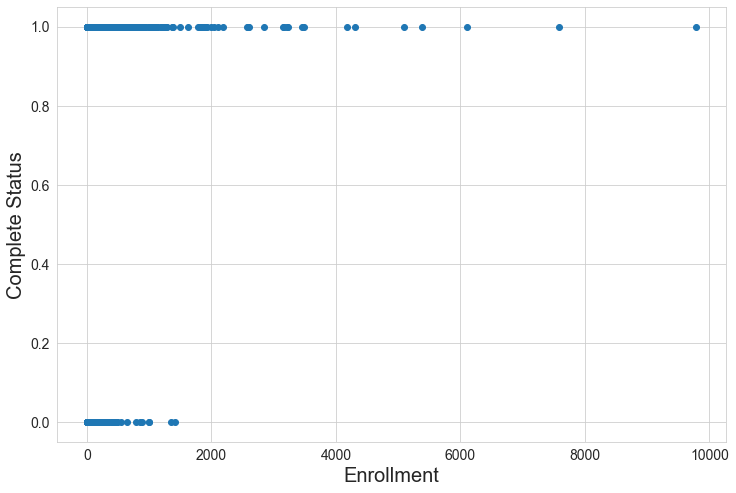

In [93]:
plt.figure(figsize=(12,8))

plt.scatter(clTrials_train["Enrollment"],
               clTrials_train["Completed_Status"])

plt.xlabel("Enrollment", fontsize=20)
plt.ylabel("Complete Status", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

We modify the df so that enrollment <= 1500. Because, it seems that if it is >1500, then it is completed.


So, in our model, first we should check whether enrollment > 1500.

For a model, if we don't use enrollment, then the original clTrials can be used.

In [94]:
#Here we introduce the modified data.

clTrials_train_modified = clTrials_train[clTrials_train['Enrollment'] <= 1500]
clTrials_test_modified = clTrials_test[clTrials_test['Enrollment'] <= 1500]

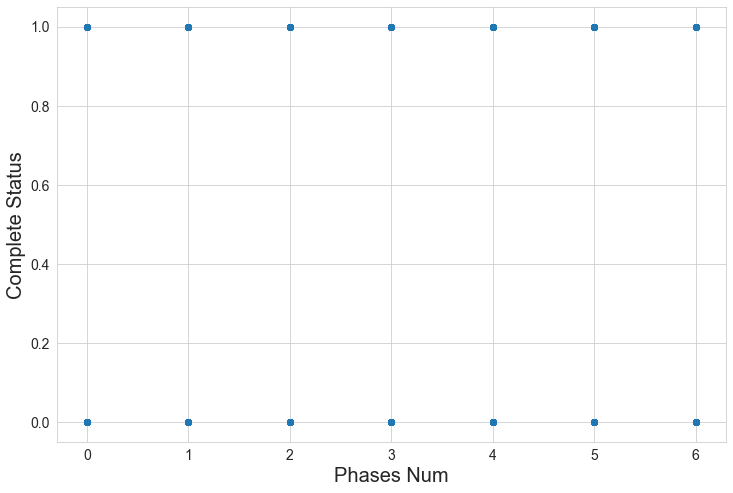

In [95]:
# We know this is stupid :))

plt.figure(figsize=(12,8))

plt.scatter(clTrials_train["Phases Num"],
               clTrials_train["Completed_Status"])

plt.xlabel("Phases Num", fontsize=20)
plt.ylabel("Complete Status", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

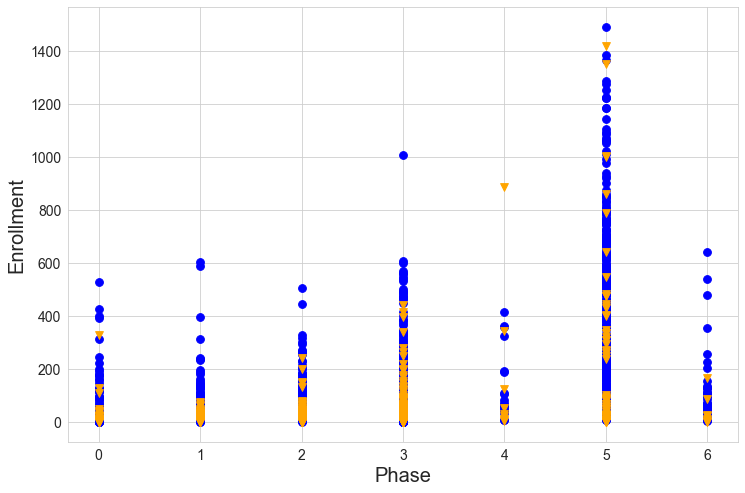

In [96]:
plt.figure(figsize=(12,8))

# plt.scatter(clTrials_train["Phases Num"],
#                clTrials_train["Enrollment"])


plt.scatter(clTrials_train_modified.loc[clTrials_train_modified.Status=='Completed']['Phases Num'],
            clTrials_train_modified.loc[clTrials_train_modified.Status =='Completed']['Enrollment'],
            c='blue',
            s=60,
            label="0")

plt.scatter(clTrials_train_modified.loc[clTrials_train_modified.Status !='Completed']['Phases Num'],
            clTrials_train_modified.loc[clTrials_train_modified.Status !='Completed']['Enrollment'],
            c='orange',
            s=60,
            marker='v',
            label="1")


plt.xlabel("Phase", fontsize=20)
plt.ylabel("Enrollment", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

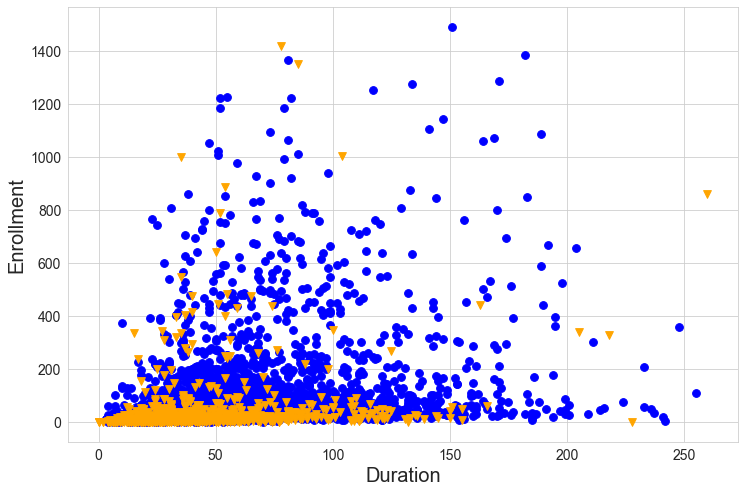

In [97]:
plt.figure(figsize=(12,8))

# plt.scatter(clTrials_train["Phases Num"],
#                clTrials_train["Enrollment"])


plt.scatter(clTrials_train_modified.loc[clTrials_train_modified.Status=='Completed']['Study Duration (months)'],
            clTrials_train_modified.loc[clTrials_train_modified.Status =='Completed']['Enrollment'],
            c='blue',
            s=60,
            label="0")

plt.scatter(clTrials_train_modified.loc[clTrials_train_modified.Status !='Completed']['Study Duration (months)'],
            clTrials_train_modified.loc[clTrials_train_modified.Status !='Completed']['Enrollment'],
            c='orange',
            s=60,
            marker='v',
            label="1")


plt.xlabel("Duration", fontsize=20)
plt.ylabel("Enrollment", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

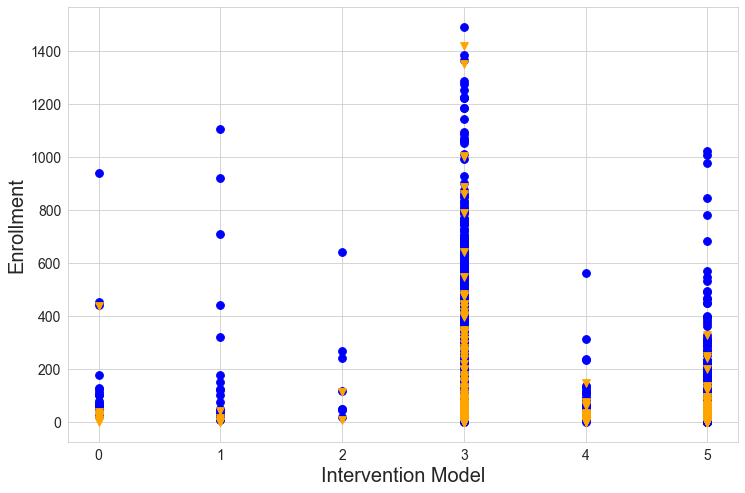

In [98]:
plt.figure(figsize=(12,8))

# plt.scatter(clTrials_train["Phases Num"],
#                clTrials_train["Enrollment"])


plt.scatter(clTrials_train_modified.loc[clTrials_train_modified.Status=='Completed']['Intervention Model'],
            clTrials_train_modified.loc[clTrials_train_modified.Status =='Completed']['Enrollment'],
            c='blue',
            s=60,
            label="0")

plt.scatter(clTrials_train_modified.loc[clTrials_train_modified.Status !='Completed']['Intervention Model'],
            clTrials_train_modified.loc[clTrials_train_modified.Status !='Completed']['Enrollment'],
            c='orange',
            s=60,
            marker='v',
            label="1")


plt.xlabel("Intervention Model", fontsize=20)
plt.ylabel("Enrollment", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

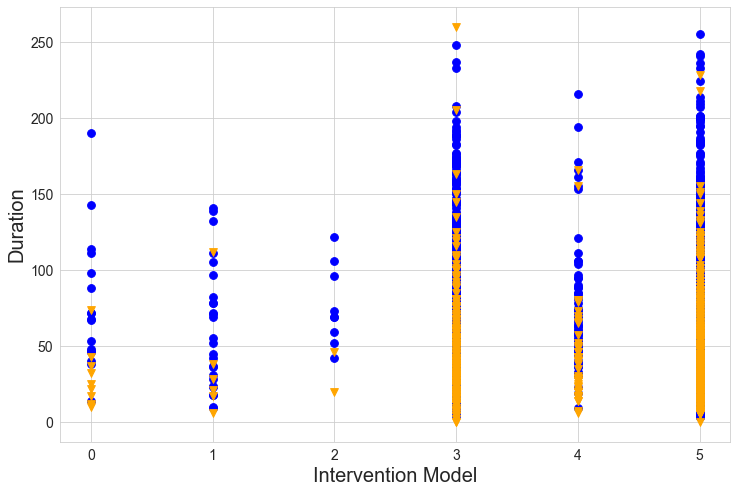

In [99]:
# NOT MODIFIED has been used here!

plt.figure(figsize=(12,8))


# plt.scatter(clTrials_train["Phases Num"],
#                clTrials_train["Enrollment"])


plt.scatter(clTrials_train.loc[clTrials_train.Status=='Completed']['Intervention Model'],
            clTrials_train.loc[clTrials_train.Status =='Completed']['Study Duration (months)'],
            c='blue',
            s=60,
            label="0")

plt.scatter(clTrials_train.loc[clTrials_train.Status !='Completed']['Intervention Model'],
            clTrials_train.loc[clTrials_train.Status !='Completed']['Study Duration (months)'],
            c='orange',
            s=60,
            marker='v',
            label="1")


plt.xlabel("Intervention Model", fontsize=20)
plt.ylabel("Duration", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

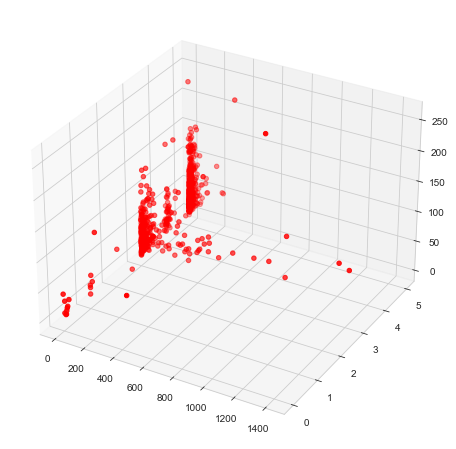

In [100]:
plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')



# Data for three-dimensional scattered points
zdata = clTrials_train_modified.loc[clTrials_train_modified.Status !='Completed']['Study Duration (months)']
xdata = clTrials_train_modified.loc[clTrials_train_modified.Status !='Completed']['Enrollment']
ydata = clTrials_train_modified.loc[clTrials_train_modified.Status !='Completed']['Intervention Model']
ax.scatter3D(xdata, ydata, zdata, color="r"); 

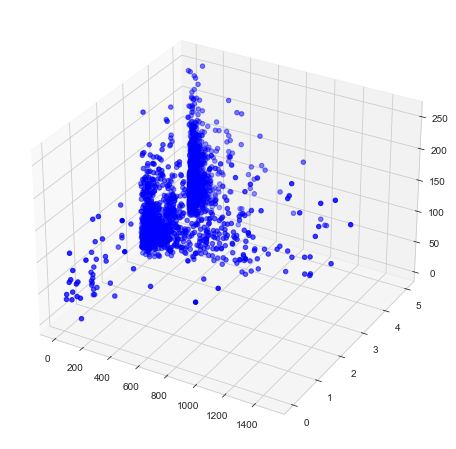

In [101]:
plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')


# Data for three-dimensional scattered points
zdata = clTrials_train_modified.loc[clTrials_train_modified.Status =='Completed']['Study Duration (months)']
xdata = clTrials_train_modified.loc[clTrials_train_modified.Status =='Completed']['Enrollment']
ydata = clTrials_train_modified.loc[clTrials_train_modified.Status =='Completed']['Intervention Model']
ax.scatter3D(xdata, ydata, zdata, color="b"); 

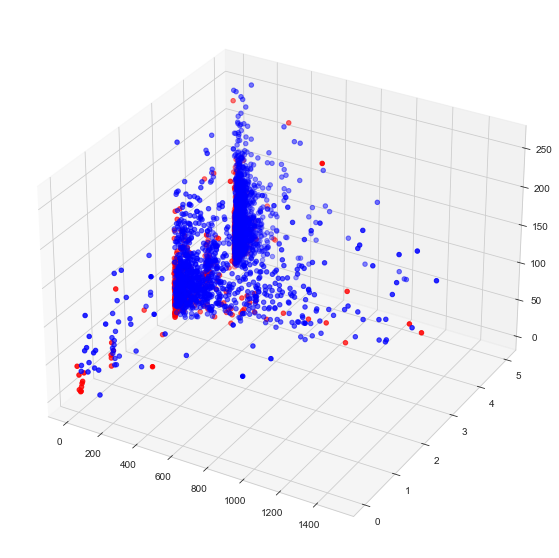

In [102]:
plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')


# Data for three-dimensional scattered points
zdata = clTrials_train_modified.loc[clTrials_train_modified.Status =='Completed']['Study Duration (months)']
xdata = clTrials_train_modified.loc[clTrials_train_modified.Status =='Completed']['Enrollment']
ydata = clTrials_train_modified.loc[clTrials_train_modified.Status =='Completed']['Intervention Model']
ax.scatter3D(xdata, ydata, zdata, color="b"); 

Zdata = clTrials_train_modified.loc[clTrials_train_modified.Status !='Completed']['Study Duration (months)']
Xdata = clTrials_train_modified.loc[clTrials_train_modified.Status !='Completed']['Enrollment']
Ydata = clTrials_train_modified.loc[clTrials_train_modified.Status !='Completed']['Intervention Model']
ax.scatter3D(Xdata, Ydata, Zdata, color="r"); 

## Use k-nearest neighbor model.

In [103]:
knn = KNeighborsClassifier(27)

knn.fit(clTrials_train_modified[['Study Duration (months)', 'Enrollment', 'Intervention Model']],
           clTrials_train_modified.Completed_Status)


KNeighborsClassifier(n_neighbors=27)

In [104]:
Pred = knn.predict(clTrials_test_modified[['Study Duration (months)', 'Enrollment', 'Intervention Model']])

In [105]:
TEST = list(clTrials_test_modified['Completed_Status'])
c=0
for i in range(len(Pred)):
    if Pred[i] == TEST[i]:
        c = c+1
        
print(c/len(Pred))


0.8268348623853211


### With k-nearest approach, where k=5, we get 80% accuracy. With k = 27, we get ~83%
### To try with different k values, we should first clean/rearrange the code first.

## Now use Decision Tree Classifier

In [ ]:
tree_clf = DecisionTreeClassifier()